# Lab 14: DQN
- Vanilla DQN for Atari image grayscale + train2 + playgame2
        - PongDeterministic
        - SpaceInvaders

# Vanilla DQN for Atari

In [1]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [3]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

In [5]:
import time
def play_game(model):
    done = False
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        env.render()
        time.sleep(0.03)
        state = next_state

In [6]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [7]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

## DQN for Atari games

How about Atari games? It's possible as we
saw from the Mnih et al. (2015) paper in *Nature*, but since the game has *images* as inputs, we have to from image inputs to look like states
to the DQN model.

In the example below, we get a state image, convert to grayscale, and reshape it into a 1D vector for input to the DQN class.

Let's play *Pong*, the first commercially successful video game.

In [8]:
env_id = 'PongDeterministic-v4'
env = gym.make(env_id)

Pong has 6 possible actions. You can check the meaning of each action as below:

In [9]:
print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


Here's a screen processing function to downsize the image and convert to grayscale:

In [10]:
import torchvision.transforms as T
from PIL import Image
image_size = 84

transform = T.Compose([T.ToPILImage(),  # from tensors to image data
                       T.Grayscale(num_output_channels=1), # convert to grayscale with 1 channel
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC), # resize to 84*84 by using Cubic interpolation
                       T.ToTensor()]) # convert back to tensor

def get_state(observation):
    # Numpy: Use transpose(a, argsort(axes)) to invert the transposition of tensors when using the axes keyword argument.
    # Example: x = np.ones((1, 2, 3))
    # np.transpose(x, (1, 0, 2)).shape --> (2, 1, 3)
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

Let's change the DQN input to be an 84$\times$84 image:

In [11]:
model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model

DQN(
  (layers): Sequential(
    (0): Linear(in_features=7056, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)

We have to modify the training function a bit:

In [12]:
def train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    ######################################################
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        ###################################################################
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # convert observation state to image state, and reshape as 1D size
            state = get_state(obs).view(image_size * image_size)
            ###################################################################
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

Agent training (episode1) Avg Reward 0.0:   0%|                                             | 0/100001 [00:00<?, ?it/s]<ipython-input-7-4a879285f6b4>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode9) Avg Reward 0.0:   0%|                                             | 0/100001 [00:00<?, ?it/s]<ipython-input-6-d0bb01164c5d>:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode100001) Avg Reward 0.25944740552594475: 100%|███████████| 100001/100001 [43:06<00:00, 38.67it/s]


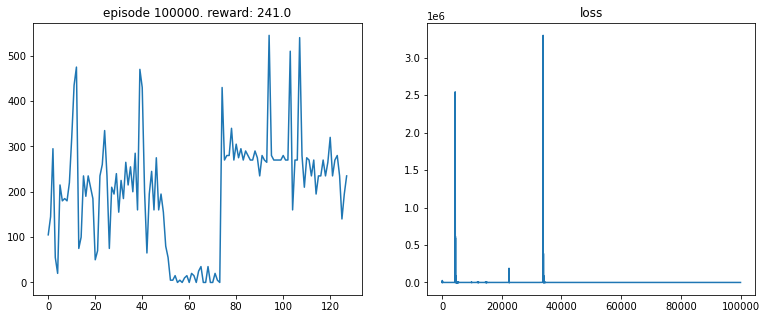

In [17]:
model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 100000, batch_size=32, gamma = 0.99)

### Simulate pong

In [18]:
def play_game2(model):
    done = False
    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    #################################################################
    while(not done):
        action = model.act(state, epsilon_final)
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        #################################################################
        env.render()
        time.sleep(0.03)
        state = next_state

In [19]:
play_game2(model)
time.sleep(3)
env.close()

<ipython-input-6-d0bb01164c5d>:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)


Wooooo! How easy!!!

## Other Atari games: Space Invaders

Now let's try Space Invaders.

In [20]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)


model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 20000, batch_size=32, gamma = 0.99)

Agent training (episode29) Avg Reward 0.0:   0%|                                   | 24/20001 [00:00<01:25, 233.17it/s]<ipython-input-6-d0bb01164c5d>:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.0:   0%|                                   | 24/20001 [00:00<01:25, 233.17it/s]

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


<ipython-input-7-4a879285f6b4>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode6443) Avg Reward 0.20797765016296757:  32%|█████▏          | 6442/20001 [03:00<06:19, 35.73it/s]


KeyboardInterrupt: 

In [ ]:
play_game2(model)
time.sleep(3)
env.close()